In [1]:
pip install datasets tensorflow opencv-python matplotlib pandas scikit-learn

In [2]:
# STEP 0: Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128
DATASET_PATH = "/content/drive/MyDrive/garbage_classification"  # Change to your path

images = []
labels = []

print("[INFO] Loading and processing TrashNet dataset...")

def enhance_image(img):
    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert BGR to RGB (important for pretrained CNNs)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize with MobileNetV2 preprocess_input (scales to [-1,1])
    img = preprocess_input(img.astype("float32"))

    return img

# ========================
# Load dataset
# ========================
for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            enhanced_img = enhance_image(img)
            images.append(enhanced_img)
            labels.append(label_folder)
        except Exception as e:
            print(f"[WARN] Skipped corrupt image: {img_path} - {e}")

# ========================
# Convert to NumPy
# ========================
X = np.array(images, dtype="float32")
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print(f"[INFO] Dataset ready: {len(X_train)} training samples, {len(X_test)} test samples")
print(f"[INFO] Classes: {le.classes_}")


[INFO] Loading and processing TrashNet dataset...
[INFO] Dataset ready: 7400 training samples, 1850 test samples
[INFO] Classes: ['biological' 'brown-glass' 'cardboard' 'green-glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash' 'white-glass']


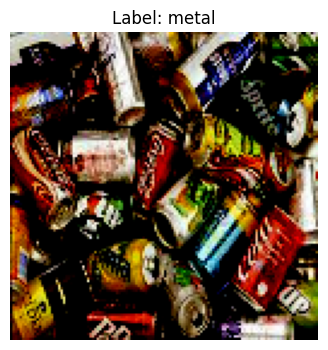

In [6]:
import matplotlib.pyplot as plt

# Show a sample image from the training set
index = 3000  # Change this to see other images
sample_image = X_train[index]

plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Label: {le.inverse_transform([np.argmax(y_train[index])])[0]}")
plt.axis("off")
plt.show()

<Axes: >

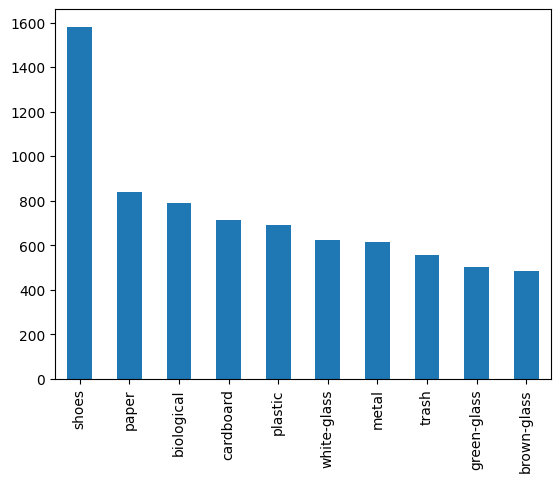

In [7]:
import pandas as pd
pd.Series(le.inverse_transform(np.argmax(y_train, axis=1))).value_counts().plot(kind='bar')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ========================
# Data Augmentation
# ========================
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator()  # no augmentation for validation/test

train_data = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
test_data = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 128  # keep same as dataset

# Load MobileNetV2 base
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation="softmax")(x)  # dynamically set classes

model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Compile
model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("efficientnet_b0_best.keras", save_best_only=True, monitor="val_accuracy")
]

history_eff = model_mobilenet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - accuracy: 0.5368 - loss: 1.5207 - val_accuracy: 0.8757 - val_loss: 0.3750 - learning_rate: 0.0010
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.8547 - loss: 0.4354 - val_accuracy: 0.8924 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8881 - loss: 0.3267 - val_accuracy: 0.9005 - val_loss: 0.3018 - learning_rate: 0.0010
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8898 - loss: 0.3246 - val_accuracy: 0.9027 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9098 - loss: 0.2740 - val_accuracy: 0.9086 - val_loss: 0.2858 - learning_rate: 0.0010
Epoch 6/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9099 - loss: 0.2546 - val_accuracy: 0.9081 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 7/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9156 - loss:

In [21]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.2 MB/s eta 0:00:00


In [11]:
import keras_tuner
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Define model building function

### Subtask:
Create a function that defines your model and takes hyperparameters as input.


**Reasoning**:
The subtask is to create a function that defines the model for KerasTuner. This involves loading the base model, adding layers, defining hyperparameters for dropout and learning rate using `keras_tuner.HyperParameters`, compiling the model, and returning it.



In [12]:
def build_model(hp):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base

    x = GlobalAveragePooling2D()(base_model.output)

    # Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(dropout_rate)(x)

    # Output layer (10 classes based on your data)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Define hyperparameter search space

### Subtask:
Define the range and types of hyperparameters to search over.


## Initialize and run tuner

### Subtask:
Set up the KerasTuner object and start the search for the best hyperparameters.


**Reasoning**:
Instantiate the KerasTuner RandomSearch tuner and start the hyperparameter search using the defined build_model function, training data, validation data, epochs, and callbacks.



In [16]:
# Step 1: Instantiate the KerasTuner RandomSearch tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_tuning_dir',
    project_name='trashnet_tuning'
)

print("[INFO] Starting hyperparameter search...")

# Step 2: Start the hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=15,  # Limiting epochs for tuning speed
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

print("[INFO] Hyperparameter search complete.")

Trial 10 Complete [00h 01m 59s]
val_accuracy: 0.9118918776512146

Best val_accuracy So Far: 0.9227027297019958
Total elapsed time: 00h 28m 13s
[INFO] Hyperparameter search complete.


In [17]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] Best Hyperparameters:")
print(f"Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Learning Rate: {best_hp.get('learning_rate')}")

# Build the best model
best_model = tuner.hypermodel.build(best_hp)

# Compile again (sometimes tuner already does, but just to be sure)
best_model.compile(
    optimizer=Adam(learning_rate=best_hp.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


[INFO] Best Hyperparameters:
Dropout Rate: 0.30000000000000004
Learning Rate: 0.0016395772926195201


In [18]:
history = best_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,   # More epochs since now we’re training the best model
    callbacks=callbacks,
    batch_size=32,
    verbose=1
)


Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step - accuracy: 0.6492 - loss: 1.0976 - val_accuracy: 0.8924 - val_loss: 0.3299 - learning_rate: 0.0016
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8951 - loss: 0.3198 - val_accuracy: 0.9016 - val_loss: 0.3246 - learning_rate: 0.0016
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9241 - loss: 0.2177 - val_accuracy: 0.9086 - val_loss: 0.3119 - learning_rate: 0.0016
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9350 - loss: 0.1895 - val_accuracy: 0.9141 - val_loss: 0.2892 - learning_rate: 0.0016
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9506 - loss: 0.1513 - val_accuracy: 0.9162 - val_loss: 0.2867 - learning_rate: 0.0016
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9471 - loss: 0.1469 - val_accuracy: 0.9092 - val_loss: 0.3077 - learning_rate: 0.0016
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9495 - loss: 

In [25]:
# Save model in modern Keras format
best_model.save("mobilenet_trash.keras")

# Load model
from tensorflow.keras.models import load_model
loaded_model = load_model("mobilenet_trash.keras")

# Recompile to ensure metrics are set
loaded_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
import pickle

# Save model with pickle
with open("mobilenet_trashn.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Load model later
with open("mobilenet_trashn.pkl", "rb") as f:
    loaded_model = pickle.load(f)


In [22]:
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


[RESULT] Test Accuracy: 0.9162, Test Loss: 0.2867


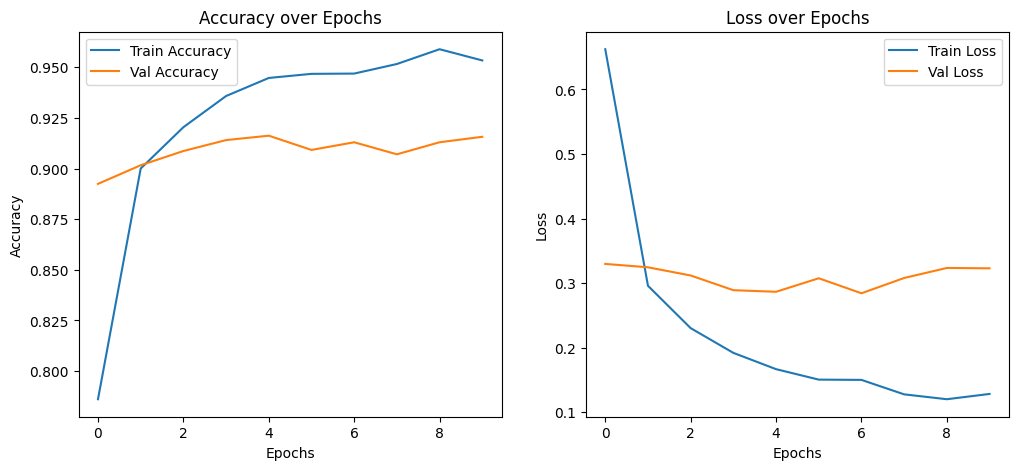

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       197
           1       0.92      0.93      0.93       121
           2       0.93      0.92      0.93       178
           3       0.94      0.90      0.92       126
           4       0.81      0.87      0.84       154
           5       0.91      0.90      0.91       210
           6       0.78      0.86      0.82       173
           7       0.98      0.99      0.98       396
           8       0.93      0.93      0.93       139
           9       0.92      0.77      0.84       156

    accuracy                           0.92      1850
   macro avg       0.91      0.90      0.91      1850
weighted avg       0.92      0.92      0.92      1850



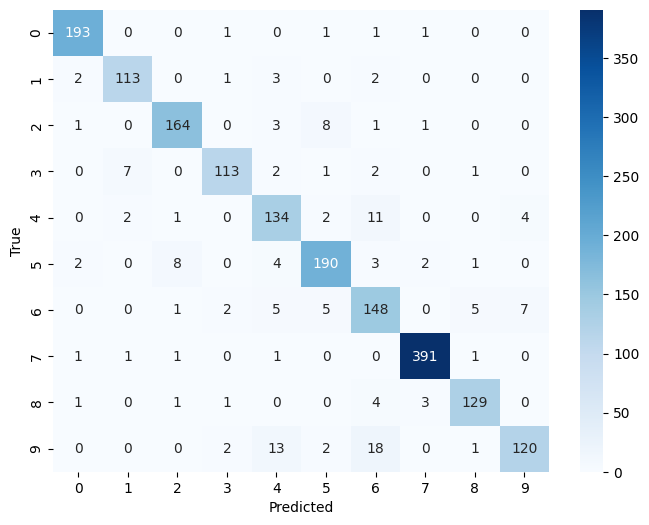

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [27]:
import pickle

# Save model architecture and weights
model_data = {
    "architecture": best_model.to_json(),   # JSON of the model
    "weights": best_model.get_weights()     # list of numpy arrays
}

# Save as pickle file
with open("mobilenet_trash.pkl", "wb") as f:
    pickle.dump(model_data, f)


In [28]:
from tensorflow.keras.models import model_from_json
import pickle

# Load pickle file
with open("mobilenet_trash.pkl", "rb") as f:
    model_data = pickle.load(f)

# Reconstruct model
loaded_model = model_from_json(model_data["architecture"])
loaded_model.set_weights(model_data["weights"])

# Compile before training or evaluating
loaded_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [29]:
from google.colab import files

files.download("mobilenet_trash.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predict image

In [37]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 128  # same as training

def preprocess_single_image_for_display(img_path):
    """
    Reads an image, resizes for MobileNetV2, returns both:
    - img_rgb: for displaying
    - img_input: preprocessed for model prediction
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or unreadable: {img_path}")

    # Resize and convert BGR -> RGB
    img_rgb = cv2.cvtColor(cv2.resize(img, (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB)

    # Preprocess for model
    img_input = preprocess_input(img_rgb.astype("float32"))
    img_input = np.expand_dims(img_input, axis=0)

    return img_rgb, img_input


In [38]:
def show_image_and_predict(model, img_path, label_encoder):
    # Preprocess
    img_rgb, img_input = preprocess_single_image_for_display(img_path)

    # Predict
    preds = model.predict(img_input)
    class_idx = np.argmax(preds, axis=1)[0]
    class_label = label_encoder.inverse_transform([class_idx])[0]
    confidence = preds[0][class_idx]

    # Show image
    plt.figure(figsize=(4,4))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{class_label} ({confidence*100:.2f}%)")
    plt.show()

    return class_label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


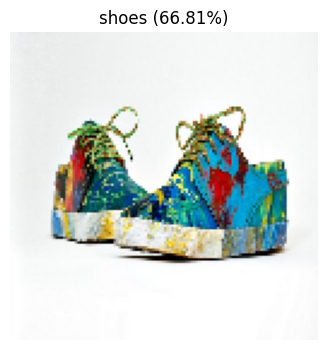

Predicted Class: shoes (66.81% confidence)


In [40]:
img_path = "/content/84a57c1a5ba6f91ba50671c8bd5345d1.jpg"
predicted_class, confidence = show_image_and_predict(best_model, img_path, le)

print(f"Predicted Class: {predicted_class} ({confidence*100:.2f}% confidence)")
